In [1]:
# load datasets from huggingface

from datasets import load_dataset
import warnings

warnings.filterwarnings('ignore')
dataset = load_dataset("StephanAkkerman/financial-tweets-crypto")
dataset

DatasetDict({
    train: Dataset({
        features: ['timestamp', 'tweet_text', 'tweet_url', 'tweet_type', 'price_of_ticker', 'change_of_ticker', 'tickers_mentioned', 'category'],
        num_rows: 47567
    })
})

In [2]:
# extract timestamp, tweet_text, tweet_type(i.e. retweet/quote tweet/...), tickers_mentioned(i.e. btc/eth/...)
import pandas as pd
df_tweet = pd.DataFrame([dataset['train']['timestamp'], 
                         dataset['train']['tweet_text'], 
                        dataset['train']['tweet_type'],
                        dataset['train']['tickers_mentioned']])
df_tweet = df_tweet.T
df_tweet

,0,1,2,3
0,2023-11-15T12:56:58.882000+00:00,$TIA\n\nMore new highs. 🔥🔥,tweet,['$TIA']
1,2023-11-15T12:56:48.089000+00:00,$MKR,tweet,['$MKR']
2,2023-11-15T12:52:57.991000+00:00,"#lina $lina is wild, highly volatile\nLong onl...",tweet,['$LINA']
3,2023-11-15T12:52:49.311000+00:00,$SUKU\n\nExpecting more upside as long as this...,tweet,['$SUKU']
4,2023-11-15T12:41:42.795000+00:00,RT @CryptoNoanGemz: Postponed due to some issues,retweet,['$FORT']
...,...,...,...,...
47562,2022-01-02T21:58:00.402000+00:00,"@ShardiB2 $LTC, $NEO, $EOS terrible investment",tweet,"['$LTC', '$NEO', '$EOS']"
47563,2022-01-02T18:35:38.797000+00:00,How are the $LTC maxi’s holding up?,tweet,['$LTC']
47564,2021-12-27T20:12:12.338000+00:00,$BITO looks like it may have found a bottom,tweet,['$BITO']
47565,2021-12-27T20:11:57.933000+00:00,$SUSHI - $9’s tagged \n\nLovely setup - easy ...,tweet,['$SUSHI']


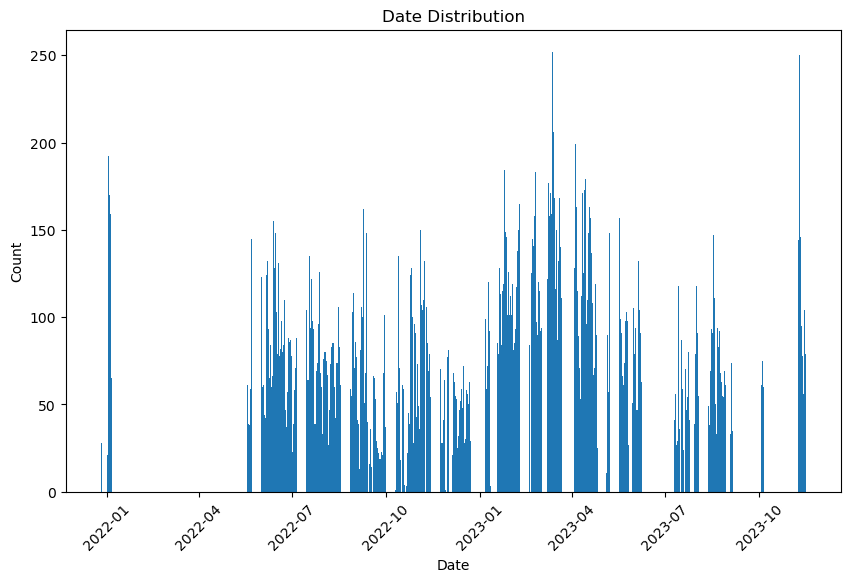

In [3]:
# Preprocess and visualize the time distribution of data
import matplotlib.pyplot as plt
import datetime

# Delete tweets without timestamp (These tweets generally only contain images)
df_tweet_dna = df_tweet.dropna(axis=0)
df_tweet_dna.columns = ['timestamp', 'text', 'type', 'tickers']
df_tweet_dna.sort_values(by='timestamp', inplace=True)
df_tweet_dna = df_tweet_dna.reset_index().drop('index', axis=1)

# Visualize the day distribution of data
dates = []
for dt in df_tweet_dna['timestamp'].values:
    dt_obj = datetime.datetime.fromisoformat(dt)
    date_only = dt_obj.date()
    dates.append(date_only)

from collections import Counter
date_counts = Counter(dates)

plt.figure(figsize=(10, 6)) 
plt.bar(date_counts.keys(), date_counts.values())  
plt.xlabel('Date')  
plt.ylabel('Count') 
plt.title('Date Distribution')  
plt.xticks(rotation=45)  
plt.show()

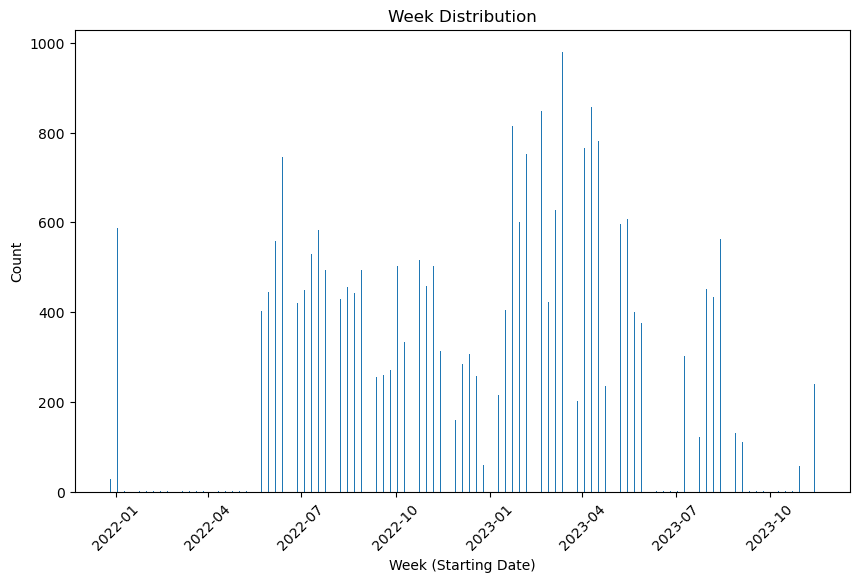

In [4]:
# Visualize the week distribution of data

start_date = dates[0]

# Get the first day of the week
first_day_of_week = start_date - datetime.timedelta(days=start_date.weekday())

# Get the last day of the week
end_date_of_week = first_day_of_week + datetime.timedelta(days=6)

weeks = {}
current_week_start = first_day_of_week

# Distribute days into weeks
for date in dates:
    if date < current_week_start:
        continue
    elif date < end_date_of_week:
        if current_week_start not in weeks:
            weeks[current_week_start] = []
        weeks[current_week_start].append(date)
    else:
        current_week_start += datetime.timedelta(weeks=1)
        end_date_of_week += datetime.timedelta(weeks=1)
        if current_week_start not in weeks:
            weeks[current_week_start] = []
        weeks[current_week_start].append(date)

pots = []

for _ in weeks.keys():
    pots.append(len(weeks[_]))
plt.figure(figsize=(10, 6)) 
plt.bar(weeks.keys(), pots)  
plt.xlabel('Week (Starting Date)')  
plt.ylabel('Count') 
plt.title('Week Distribution')  
plt.xticks(rotation=45)  
plt.show()

In [5]:
print('Num of weeks available for train and test is %d' % (len([_ for _ in pots if _ > 7])))
print('Num of days available for train and test is %d' % len([_ for _ in date_counts.keys() if date_counts[_] > 7]))

Num of weeks available for train and test is 71
Num of days available for train and test is 402


**We will choose a day as prediction frequency**

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# This is a package made for analyzing txt data, especially for social media data
# You can see the description in https://github.com/cjhutto/vaderSentiment

analyzer = SentimentIntensityAnalyzer()
popularity = []
for i in df_tweet_dna['text'].values:
    popularity.append(analyzer.polarity_scores(i))
df_popularity = pd.DataFrame.from_records(popularity)
df_popularity

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.131,0.414,0.455,0.6908
2,0.203,0.391,0.406,0.8271
3,0.000,1.000,0.000,0.0000
4,0.000,1.000,0.000,0.0000
...,...,...,...,...
33622,0.000,1.000,0.000,0.0000
33623,0.099,0.901,0.000,-0.3412
33624,0.000,1.000,0.000,0.0000
33625,0.000,1.000,0.000,0.0000


In [7]:
# Concat two dataframes
df_concat = pd.concat([df_tweet_dna, df_popularity], axis=1, ignore_index=True)
df_concat.columns = ['timestamp', 'text', 'type', 'tickers', 'neg', 'neu', 'pos', 'compound']
df_concat

,timestamp,text,type,tickers,neg,neu,pos,compound
0,2021-12-27T17:14:52.621000+00:00,Oh my $AKRO,tweet,['$AKRO'],0.000,1.000,0.000,0.0000
1,2021-12-27T17:17:22.604000+00:00,$DYDX +8% 😂 Nice scalp,tweet,['$DYDX'],0.131,0.414,0.455,0.6908
2,2021-12-27T17:26:03.188000+00:00,$SUSHI BBBBOOOOOPP 😂😂😂,tweet,['$SUSHI'],0.203,0.391,0.406,0.8271
3,2021-12-27T17:27:58.245000+00:00,$gala,tweet,['$GALA'],0.000,1.000,0.000,0.0000
4,2021-12-27T17:28:50.980000+00:00,RT @CryptoNTez: $DOT,tweet,['$DOT'],0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
33622,2023-11-15T12:52:49.311000+00:00,$SUKU\n\nExpecting more upside as long as this...,tweet,['$SUKU'],0.000,1.000,0.000,0.0000
33623,2023-11-15T12:52:57.991000+00:00,"#lina $lina is wild, highly volatile\nLong onl...",tweet,['$LINA'],0.099,0.901,0.000,-0.3412
33624,2023-11-15T12:56:48.089000+00:00,$MKR,tweet,['$MKR'],0.000,1.000,0.000,0.0000
33625,2023-11-15T12:56:52.118000+00:00,$SOL 20% bounce 🤝 $LINK 14% bounce\n\n> [@Cryp...,quote tweet,"['$LINK', '$SOL']",0.000,1.000,0.000,0.0000


In [8]:
# Save as csv
df_concat.to_csv('tweets.csv', encoding='utf-8', index=False)